In [6]:
import sys
import os
CRYPTO_INDEX_DIR_PATH = '../' 
CONFIG_FILE_PATH = '../config_parsing/example.ini'
# os.listdir(CRYPTO_INDEX_DIR_PATH)

In [7]:
sys.path.append(CRYPTO_INDEX_DIR_PATH)

import cqt
import cqt.env as env
import cqt.ledger.ledger as ledger

from cqt.strats.strategy import Strategy
import cqt.strats.strategy_double_dip as sdd
import cqt.strats.strategy_long_short_average as sma

import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

import configparser

In [67]:
class MyParser(configparser.ConfigParser):

    def as_dict(self):
        d = dict(self._sections)
        for k in d:
            d[k] = dict(self._defaults, **d[k])
            d[k].pop('__name__', None)
        return d
    
# Ideally these functions should be defined inside every class
def longShortAverageRulesParser(configSectionDict):
    rulesDict = {}
    rulesDict['method'] = configSectionDict['method']
    window_size_0 = int(configSectionDict['window_size_0']) 
    window_size_1 = int(configSectionDict['window_size_1'])
    rulesDict['window_size'] = [window_size_0, window_size_1]
    rulesDict['tolerance_up'] = float(configSectionDict['tolerance_up'])
    rulesDict['tolerance_down'] = float(configSectionDict['tolerance_down'])
    return rulesDict

def testPortfolioFactory(configSectionDict):
    cash = float(configSectionDict['cash'])
    assets = {}
    assets['btc'] = float(configSectionDict['btc'])
    assets['eth'] = float(configSectionDict['eth'])
    portfolio = ledger.Ledger(assets, cash)
    return portfolio

def testEnvironmentFactory(configSectionDict):
    # for testing purpose, hard coding it for now
    file_btc_eth = open('../data/pickle/model_btc_eth.pickle','rb')
    env_btc_eth = pickle.load(file_btc_eth)
    return env_btc_eth

def simpleMAStrategyParser(configSectionDict):
    # for testing purpose, hard coding for now
    pass

def simpleMAStrategyFactory(user_env, user_port, user_rule):
    strategy = sma.StrategySimpleMA(user_env, user_port, user_rule)
    return strategy

# Consider this as a registry for the signal/portfolio/strategies 
configParserMetaDict = {
    'signal': {
        'long_short_average': longShortAverageRulesParser,
    },
    
    'portfolio': {
        'test': testPortfolioFactory,
    },
    
    'environment': {
        'test': testEnvironmentFactory,
    },
    
    'strategy': {
        'simple_ma_strategy': simpleMAStrategyParser 
    }
}

# A generic entry point for parsing things in the config file
def parseConfigSection(configSectionDict):
    print('test input:\n',configSectionDict)
    parser = configParserMetaDict[configSectionDict['class']][configSectionDict['subclass']]
    config = parser(configSectionDict)
    return config

def run_backtest(strategy, start_date_str):
    start_date_str = '2018-01-01'
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    report = strategy.back_testing(start_date)
    return report

In [68]:
# initializing routine
configFilePath = CONFIG_FILE_PATH
parser = MyParser()
parser.read(configFilePath)
configDict = parser.as_dict()
signalsList = [value for key, value in enumerate(configDict['signals_list'].values())]
portfoliosList = [value for key, value in enumerate(configDict['portfolios_list'].values())]
environmentList = [value for key, value in enumerate(configDict['environment_list'].values())]

In [69]:
# minimal example
signalKey = signalsList[0]
portfolioKey = portfoliosList[0]
environmentKey = environmentList[0]

In [70]:
# os.listdir(configFilePath)

In [71]:
signalMetaDict = {}
signalMetaDict[signalKey] = parseConfigSection(configDict[signalKey])

#user defined test
mySignal = parseConfigSection(configDict[signalKey])
myPortfolio = parseConfigSection(configDict[portfolioKey])
myEnv = parseConfigSection(configDict[environmentKey])
print(mySignal)
print(myPortfolio)
print(myEnv)


test input:
 {'class': 'signal', 'subclass': 'long_short_average', 'method': 'moving_average', 'window_size_0': '30', 'window_size_1': '90', 'tolerance_up': '0.0', 'tolerance_down': '0.0'}
test input:
 {'class': 'signal', 'subclass': 'long_short_average', 'method': 'moving_average', 'window_size_0': '30', 'window_size_1': '90', 'tolerance_up': '0.0', 'tolerance_down': '0.0'}
test input:
 {'class': 'portfolio', 'subclass': 'test', 'cash': '100000', 'btc': '0', 'eth': '0'}
test input:
 {'class': 'environment', 'subclass': 'test'}
{'method': 'moving_average', 'window_size': [30, 90], 'tolerance_up': 0.0, 'tolerance_down': 0.0}


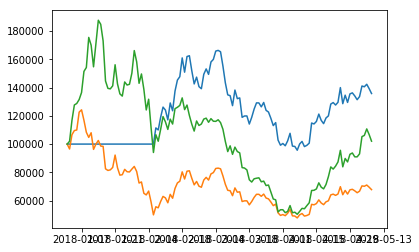

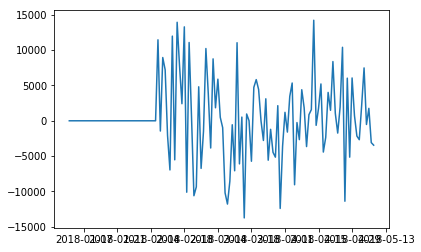

In [73]:
strategy = simpleMAStrategyFactory(myEnv, myPortfolio, mySignal)
report = run_backtest(strategy, '2018-01-01')